In [3]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re


In [4]:
csv_dir = "./allStatCSVS"
team_files = [f for f in os.listdir(csv_dir) if "_Team_" in f and f.endswith(".csv")]

frames_2024, frames_2025 = [], []

def tidy_frame(path):
    df   = pd.read_csv(path)
    year = int(re.search(r"(19|20)\d{2}", path).group())          # 2024 or 2025
    stat = os.path.basename(path).split("_Team_")[0]              # e.g. "Aces_Per_Set"
    stat = stat.replace("_Per_Set", "PerSet").replace("_", "")    # cosmetic

    # rename every column *except* "Team" so it's globally unique
    df = df.rename(columns={c: f"{stat}_{c}" for c in df.columns if c != "Team"})
    df["Year"] = year
    return df[["Team", "Year", *[c for c in df.columns if c != "Team" and c != "Year"]]]

for f in team_files:
    tidy = tidy_frame(os.path.join(csv_dir, f))
    (frames_2024 if tidy["Year"].iloc[0] == 2024 else frames_2025).append(tidy)

# -- outer‑merge everything per year -------------------------------------------
from functools import reduce
master2024 = reduce(lambda l,r: pd.merge(l,r,on=["Team","Year"], how="outer"), frames_2024)
master2025 = reduce(lambda l,r: pd.merge(l,r,on=["Team","Year"], how="outer"), frames_2025)

print("2024 shape:", master2024.shape)
print("2025 shape:", master2025.shape)


2024 shape: (55, 53)
2025 shape: (64, 53)


In [5]:
#drop na rows
master2024 = master2024.dropna(subset=["MatchW-LPctg._Pct."])
master2025 = master2025.dropna(subset=["MatchW-LPctg._Pct."])

master2024.columns

Index(['Team', 'Year', 'BlocksPerSet_Rank', 'BlocksPerSet_S',
       'BlocksPerSet_W-L', 'BlocksPerSet_Block Solos',
       'BlocksPerSet_Block Assists', 'BlocksPerSet_TB', 'BlocksPerSet_Per Set',
       'DigsPerSet_Rank', 'DigsPerSet_S', 'DigsPerSet_W-L', 'DigsPerSet_Digs',
       'DigsPerSet_Per Set', 'TeamAttacksPerSet_Rank', 'TeamAttacksPerSet_S',
       'TeamAttacksPerSet_W-L', 'TeamAttacksPerSet_Kills',
       'TeamAttacksPerSet_Errors', 'TeamAttacksPerSet_Total Attacks',
       'TeamAttacksPerSet_Per Set', 'OpponentHittingPercentage_Rank',
       'OpponentHittingPercentage_S', 'OpponentHittingPercentage_W-L',
       'OpponentHittingPercentage_Opp Kills',
       'OpponentHittingPercentage_Opp Errors',
       'OpponentHittingPercentage_Opp Attacks',
       'OpponentHittingPercentage_Opp Pct', 'AssistsPerSet_Rank',
       'AssistsPerSet_S', 'AssistsPerSet_W-L', 'AssistsPerSet_Assists',
       'AssistsPerSet_Per Set', 'AcesPerSet_Rank', 'AcesPerSet_S',
       'AcesPerSet_W-L', 'Aces

In [6]:
label = "MatchW-LPctg._Pct."

num_cols_24 = master2024.select_dtypes("number").columns
features = [c for c in num_cols_24 if c != label and c != "MatchW-LPctg._Rank" and c != "MatchW-LPctg._L" and c != "MatchW-LPctg._W"]

X_train = master2024[features]
y_train = master2024[label]

num_cols_25 = master2025.select_dtypes("number").columns
X_test = master2025[features]
y_test = master2025[label]

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

model.fit(X_train, y_train)

preds = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, preds))
print("R² :", r2_score(y_test, preds))

results = master2025[["Team", "Year"]].copy()
results["PredictedPct"] = preds
results["ActualPct"] = y_test.values
print(results.head())

MAE: 0.08588727846800111
R² : 0.5708127233819824
                                   Team  Year  PredictedPct  ActualPct
1                            BYU (MPSF)  2025      0.550642      0.708
2                       Ball St. (MIVA)  2025      0.657572      0.607
3                Barry (DI Independent)  2025      0.312479      0.435
4         Barton (Conference Carolinas)  2025      0.536945      0.577
5  Belmont Abbey (Conference Carolinas)  2025      0.597352      0.636


Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
CV MAE: 0.06808185369014741

2025 MAE: 0.08538107988413644
2025 R² : 0.5885498424579807

Head of prediction table:
                                    Team  Year  PredictedPct  ActualPct
1                            BYU (MPSF)  2025      0.539217      0.708
2                       Ball St. (MIVA)  2025      0.701571      0.607
3                Barry (DI Independent)  2025      0.325809      0.435
4         Barton (Conference Carolinas)  2025      0.521236      0.577
5  Belmont Abbey (Conference Carolinas)  2025      0.628015      0.636


<Figure size 800x1000 with 0 Axes>

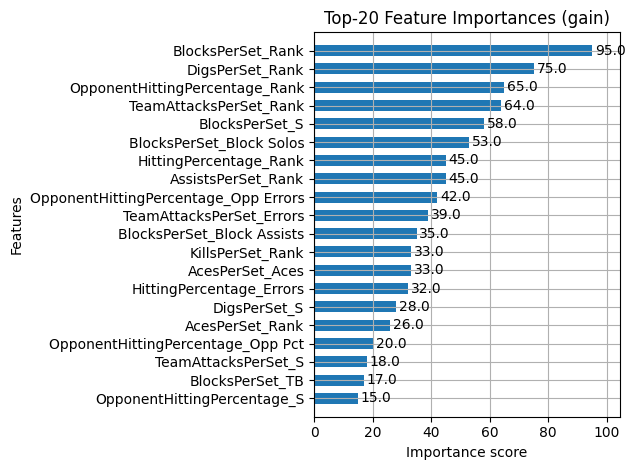

In [7]:
from sklearn.model_selection import GridSearchCV, KFold
import matplotlib.pyplot as plt


label = "MatchW-LPctg._Pct."
features = [
    c for c in master2024.select_dtypes("number").columns
    if c != label and c != "MatchW-LPctg._Rank" and c != "MatchW-LPctg._L" and c != "MatchW-LPctg._W"
]

X_train = master2024[features]
y_train = master2024[label]

X_test  = master2025[features]
y_test  = master2025[label]


param_grid = {
    "n_estimators": [200, 400, 600],
    "max_depth":    [3, 4, 5],
    "learning_rate":[0.05, 0.1, 0.2],
    "subsample":    [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
)

cv = KFold(n_splits=10, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1,
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("CV MAE:",    -grid.best_score_)

best_model = grid.best_estimator_


preds = best_model.predict(X_test)
print("\n2025 MAE:", mean_absolute_error(y_test, preds))
print("2025 R² :",  r2_score(y_test, preds))

results = master2025[["Team", "Year"]].copy()
results["PredictedPct"] = preds
results["ActualPct"]    = y_test.values
print("\nHead of prediction table:\n", results.head())


plt.figure(figsize=(8, 10))
xgb.plot_importance(best_model, max_num_features=20, height=0.6)
plt.title("Top‑20 Feature Importances (gain)")
plt.tight_layout()
plt.show()


In [8]:
# normalize
def normalize(name):
    if not isinstance(name, str):
        return ""
    base = name.split("(")[0]   # drop conference suffix
    return (
        base
        .strip()
        .lower()
        .replace(".", "")
        .replace(",", "")
        .replace("  ", " ")
    )

# re index stats tables by normalized team name
master2024["Team_norm"] = master2024["Team"].map(normalize)
master2025["Team_norm"] = master2025["Team"].map(normalize)
master2024 = master2024.set_index("Team_norm", drop=False)
master2025 = master2025.set_index("Team_norm", drop=False)

# clean matches, build features
def preprocess_matches(path, team_stats):
    df = pd.read_csv(path)
    # convert scores → numeric, drop failures
    df["Team 1 Score"] = pd.to_numeric(df["Team 1 Score"], errors="coerce")
    df["Team 2 Score"] = pd.to_numeric(df["Team 2 Score"], errors="coerce")
    df = df.dropna(subset=["Team 1 Score", "Team 2 Score"])
    df["Team 1 Score"] = df["Team 1 Score"].astype(int)
    df["Team 2 Score"] = df["Team 2 Score"].astype(int)
    # label: 1 if Team 1 wins
    df["Label"] = (df["Team 1 Score"] > df["Team 2 Score"]).astype(int)
    # normalize names
    df["T1_norm"] = df["Team 1"].map(normalize)
    df["T2_norm"] = df["Team 2"].map(normalize)
    # filter to only rows both in stats
    mask = df["T1_norm"].isin(team_stats.index) & df["T2_norm"].isin(team_stats.index)
    return df.loc[mask, ["T1_norm","T2_norm","Label"]]

def build_match_features(matches, team_stats):
    # only numeric cols except Year
    numeric_cols = [
        c for c in team_stats.select_dtypes(include="number").columns
        if c != "Year"
    ]
    rows = []
    for _, r in matches.iterrows():
        a = team_stats.loc[r["T1_norm"]]
        b = team_stats.loc[r["T2_norm"]]
        feat = {}
        for c in numeric_cols:
            feat[f"A_{c}"]     = a[c]
            feat[f"B_{c}"]     = b[c]
            feat[f"Delta_{c}"] = a[c] - b[c]
        feat["Label"] = r["Label"]
        rows.append(feat)
    return pd.DataFrame(rows)

# build test and train tables
matches2024 = preprocess_matches("2024MensNcaaGames.csv", master2024)
train_data   = build_match_features(matches2024, master2024)

matches2025 = preprocess_matches("2025MensNcaaGames.csv", master2025)
test_data    = build_match_features(matches2025, master2025)

print("Train matches:", train_data.shape)   # e.g. ( hundreds, features+1 )
print("Test  matches:", test_data.shape)    # likewise

Train matches: (579, 103)
Test  matches: (526, 103)


In [9]:
# ── 2) TRAIN ───────────────────────────────────────────────────────────────────

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# split val set
X = train_data.drop(columns=["Label"])
y = train_data["Label"]
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# fit classifier
clf = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)
clf.fit(X_train, y_train)

# val accuracy
val_pred = clf.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, val_pred))

/Users/rain/Documents/GitHub/wi25-ai-team1/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:19:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.7931034482758621


In [10]:
# test

from sklearn.metrics import accuracy_score, classification_report

# align columns
feature_cols = [c for c in train_data.columns if c != "Label"]
test_data = test_data.reindex(columns=feature_cols + ["Label"], fill_value=0)

# split features/labels
X_test = test_data[feature_cols]
y_test = test_data["Label"]

# predict & evaluate
test_pred = clf.predict(X_test)
print("Test Accuracy (2025):", accuracy_score(y_test, test_pred))
print("\nClassification Report:\n", classification_report(y_test, test_pred))

Test Accuracy (2025): 0.7433460076045627

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.83      0.80       330
           1       0.68      0.59      0.63       196

    accuracy                           0.74       526
   macro avg       0.73      0.71      0.72       526
weighted avg       0.74      0.74      0.74       526



In [11]:
# ── MATCH PREDICTION FUNCTION ──────────────────────────────────────────────────

import numpy as np
import difflib

def predict_match(team1, team2, model, stats_df):
    """
    Predicts which team will win and with what probability,
    even if one of the teams has missing stats (falls back to the mean).
    """
    # ——— name normalization
    def normalize(name):
        if not isinstance(name, str):
            return ""
        base = name.split("(")[0]
        return (
            base.strip()
                .lower()
                .replace(".", "")
                .replace(",", "")
                .replace("  ", " ")
        )
    n1, n2 = normalize(team1), normalize(team2)
    
    # ——— numeric columns 
    numeric_cols = [c for c in stats_df.select_dtypes("number").columns if c != "Year"]
    
    # ——— fetch stats, or fallback to column mean
    def get_stats(norm_name, orig_name):
        if norm_name in stats_df.index:
            return stats_df.loc[norm_name, numeric_cols]
        # warn + suggest close matches
        print(f"No stats found for “{orig_name}”. Using average stats instead.")
        choices = stats_df.index.tolist()
        sugg = difflib.get_close_matches(norm_name, choices, n=3, cutoff=0.5)
        if sugg:
            print("   Did you mean:", ", ".join(sugg))
        return stats_df[numeric_cols].mean()
    
    a = get_stats(n1, team1)
    b = get_stats(n2, team2)
    
    # ——— build feature vector
    row = []
    for c in numeric_cols:
        row.extend([ a[c], b[c], a[c] - b[c] ])
    X_match = np.array(row).reshape(1, -1)
    
    # ——— predict probabilities
    # proba[0,1] = P(label=1) = P(team1 wins)
    proba = model.predict_proba(X_match)[0, 1]
    
    if proba >= 0.5:
        return team1, proba
    else:
        return team2, 1 - proba

# ── USAGE EXAMPLE ──────────────────────────────────────────────────────────────

winner, win_prob = predict_match("long beach st", "UC San Diego", clf, master2025)

print(f"Predicted winner: {winner}")
print(f"Win probability: {win_prob*100:.1f}%")

Predicted winner: long beach st
Win probability: 90.3%


In [12]:
clf.save_model('xgb_model.json')